#EP01 - Cálculo Numérico

Título: Autovalores e Autovetores de Matrizes Tridiagonais Simétricas - O Algoritmo QR

# Importando Bibliotecas

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import time
import cv2

# Tarefa 1 - Algoritmo QR com deslocamento Espectral

In [2]:
def K_diagonal_indices(A, K):
    rows, cols = np.diag_indices_from(A)
    if K < 0:
        return rows[-K:], cols[:K]
    elif K > 0:
        return rows[:-K], cols[K:]
    else:
        return rows, cols

In [3]:
def make_A(N, diag_values=1, subdiag_values=0):
    A = np.zeros((N, N))
    np.fill_diagonal(A, diag_values)
    A[K_diagonal_indices(A, -1)] = subdiag_values
    A[K_diagonal_indices(A,  1)] = subdiag_values
    return A

In [4]:
def get_cos_and_sen_k(A, k):
    cos = np.divide(A[k  , k], np.sqrt(np.square(A[k, k]) + np.square(A[k+1, k])))
    sin = np.divide(A[k+1, k], np.sqrt(np.square(A[k, k]) + np.square(A[k+1, k])))
    return cos, sin

In [5]:
def rotation_matrix(A, k):
    n = A.shape[0]
    i, j = k, k + 1

    G = np.zeros((n, n))

    c, s = get_cos_and_sen_k(A, k)

    np.fill_diagonal(G, 1)
    G[i, i] =  c
    G[j, j] =  c
    G[j, i] = -s
    G[i, j] =  s

    return G

In [6]:
def QR_decomposition(A):
    R = A.copy()
    Q = []

    for k in range(A.shape[0] - 1):
        Q.append(rotation_matrix(R, k))
        R = Q[k] @ R
    
    final_Q = Q[-1]
    for i in range(len(Q) - 2, -1, -1):
        final_Q = final_Q @ Q[i]

    Q = final_Q

    return final_Q, R

In [7]:
def sgn(number):
    if number >= 0:
        return 1
    return -1

In [8]:
def Wilkinson(A):
    n = A.shape[0]
    d_k = (A[n-2, n-2] - A[n-1, n-1])/2
    return A[n-1, n-1] + d_k - sgn(d_k) * np.sqrt(np.square(d_k) + np.square(A[n-1, n-2]))

In [9]:
def QR_algorithm(A, threshold=1e-6, spectral_shifts=True):
    A0 = A.copy()
    V0 = np.identity(A.shape[0])
    μ_k = 0
    contador = 0
    eigenvalues = []
    eigenvectors = []

    if spectral_shifts:
        for k in range(A.shape[0], 1, -1):
            while abs(A0[-1, -2]) >= threshold and A0.shape[0] > 2:
                Q, R = QR_decomposition(A0 - μ_k * np.identity(A0.shape[0]))
                A0 = R @ Q.T + μ_k * np.identity(A0.shape[0])
                V0 = V0 @ Q.T
                μ_k = Wilkinson(A0)
                contador += 1
            
            eigenvalues.append(A0[-1, -1])
            eigenvectors.append(V0[ :, -1])

            A0 = A0[:k-1, :k-1]
            V0 = V0[:   , :k-1]            
    
    else:
        for k in range(A.shape[0], 1, -1):
            while abs(A0[-1, -2]) > threshold:
            
                Q, R = QR_decomposition(A0)
                A0 = R @ Q.T
                V0 = V0 @ Q.T
                contador += 1

            eigenvalues.append(A0[-1, -1])
            eigenvectors.append(V0[ :, -1])

            A0 = A0[:k-1, :k-1]
            V0 = V0[:   , :k-1]
        
    
    eigenvalues.append(A0[-1, -1])
    eigenvectors.append(V0[ :, -1])
    
    A0[abs(A0) < threshold] = 0
    V0[abs(V0) < threshold] = 0
    
    return np.asarray(eigenvalues)[::-1], np.asarray(eigenvectors)[::-1], contador

In [10]:
def print_values(values, symbol='θ'):
    if symbol == "λ":
        for i in range(len(values)):
            if i > 9:
                print("{}{}:".format(symbol, i + 1), values[i])
            else:
                print("{}{} :".format(symbol, i + 1), values[i])
    
    if symbol == "Λ":
        for i in range(len(values)):
            if i > 9:
                print("{}{}:\n".format(symbol, i + 1), values[i])
            else:
                print("{}{} :\n".format(symbol, i + 1), values[i])

    print()

In [11]:
k_with_shift = []
k_without_shift = []
t_with_shift = []
t_without_shift = []

for n in np.arange(2, 76):
    A = make_A(n, 2, -1)

    t = time.process_time()
    eigenvalues , eigenvectors , iterations  = QR_algorithm(A, threshold=1e-6, spectral_shifts=False)
    Δt = time.process_time() - t

    t = time.process_time()
    eigenvalues_, eigenvectors_, iterations_ = QR_algorithm(A, threshold=1e-6, spectral_shifts=True)
    Δt_ = time.process_time() - t

    if n in [4, 8, 16, 32]:
        print("\n" + "="*50 + " N = " + str(n) + " " + "="*50 + "\n")
        print("Sem deslocamento espectral")
        print("K =", iterations)
        print("Com deslocamento espectral")
        print("K =", iterations_)
        print_values(eigenvalues_, symbol='λ')
        print_values(eigenvectors_, symbol='Λ')

    k_with_shift.append(iterations_)
    k_without_shift.append(iterations)
    t_with_shift.append(Δt_)
    t_without_shift.append(Δt)


================================================== N = 4 ==================================================

Sem deslocamento espectral
K = 45
Com deslocamento espectral
K = 7
λ1 : 3.6115407507457316
λ2 : 2.6245272267540583
λ3 : 1.3819660112501053
λ4 : 0.3819660112501052

Λ1 :
 [ 0.41900847 -0.62950062  0.56958924 -0.32206982]
Λ2 :
 [ 0.56958924 -0.32206982 -0.41900847  0.62950062]
Λ3 :
 [ 0.60150096  0.37174803 -0.37174803 -0.60150096]
Λ4 :
 [0.37174803 0.60150096 0.60150096 0.37174803]


================================================== N = 8 ==================================================

Sem deslocamento espectral
K = 143
Com deslocamento espectral
K = 17
λ1 : 3.876868160786339
λ2 : 3.5346059670234324
λ3 : 2.9999999999998885
λ4 : 2.3472963553339725
λ5 : 1.6527036446660694
λ6 : 1.0000000000000704
λ7 : 0.46791111376204386
λ8 : 0.1206147584281833

Λ1 :
 [ 0.18644095 -0.34143536  0.44152163 -0.47628343  0.44883144 -0.37201074
  0.26239049 -0.13484808]
Λ2 :
 [ 0.28818694 -0.436761

In [12]:
for i in [4, 8, 16, 32]:
    Autovalores = {}
    Autovetores = {}

    A = make_A(i, 2, -1)
    eigenvalues_, eigenvectors_, iterations_ = QR_algorithm(A, threshold=1e-6, spectral_shifts=True)
    
    Autovalores['Nome'] = np.array(['λ{}'.format(j + 1) for j in range(i)])
    Autovalores['λ'] = eigenvalues_

    pd.DataFrame(Autovalores).to_csv('Autovalores {}.csv'.format(i), index=False)

    Autovetores['Nome'] = np.array(['Λ {}'.format(j + 1) for j in range(i)])

    for k in range(i):
        Autovetores['Pos {}'.format(k)] = eigenvectors_[:, k]

    pd.DataFrame(Autovetores).to_csv('Autovetores {}.csv'.format(i), index=False)

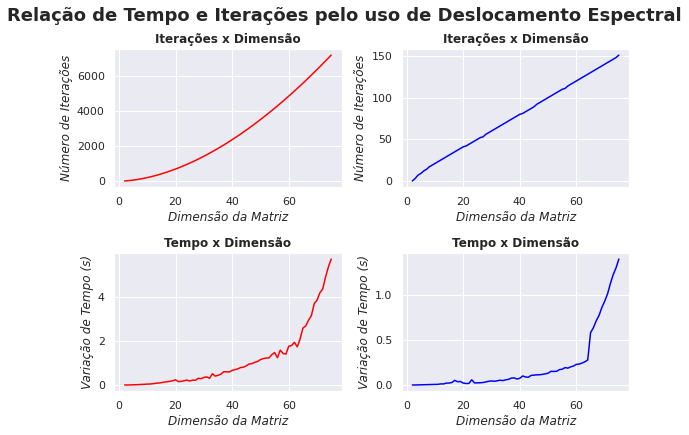

In [13]:
df = pd.DataFrame({
    'Matrix Dimension' : np.array(np.arange(2, 76)),
    'Iterations_Shifted'       : k_with_shift,
    'Iterations_Not_Shifted'   : k_without_shift,
    'ΔTime_Shifted'            : t_with_shift,
    'ΔTime_Not_Shifted'        : t_without_shift,

})

sns.set(rc={'figure.figsize':(8.26772, 11.69291/2)})

ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)

sns.lineplot(ax=ax1, x='Matrix Dimension', y='Iterations_Not_Shifted', data=df, color='red')
sns.lineplot(ax=ax2, x='Matrix Dimension', y='Iterations_Shifted', data=df, color='blue')
sns.lineplot(ax=ax3, x='Matrix Dimension', y='ΔTime_Not_Shifted', data=df, color='red')
sns.lineplot(ax=ax4, x='Matrix Dimension', y='ΔTime_Shifted', data=df, color='blue')

ax1.set_title("Iterações x Dimensão", fontsize=12, fontweight='bold')
ax2.set_title("Iterações x Dimensão", fontsize=12, fontweight='bold')
ax3.set_title("Tempo x Dimensão", fontsize=12, fontweight='bold')
ax4.set_title("Tempo x Dimensão", fontsize=12, fontweight='bold')

ax1.set_xlabel('Dimensão da Matriz', fontsize=12, fontstyle='italic')
ax2.set_xlabel('Dimensão da Matriz', fontsize=12, fontstyle='italic')
ax3.set_xlabel('Dimensão da Matriz', fontsize=12, fontstyle='italic')
ax4.set_xlabel('Dimensão da Matriz', fontsize=12, fontstyle='italic')
ax1.set_ylabel('Número de Iterações', fontsize=12, fontstyle='italic')
ax2.set_ylabel('Número de Iterações', fontsize=12, fontstyle='italic')
ax3.set_ylabel('Variação de Tempo (s)', fontsize=12, fontstyle='italic')
ax4.set_ylabel('Variação de Tempo (s)', fontsize=12, fontstyle='italic')

plt.suptitle("Relação de Tempo e Iterações pelo uso de Deslocamento Espectral", fontweight='bold', fontsize=18, y=1.03)

plt.tight_layout()

fig = plt.gcf()
fig.savefig("Tempo vs Iterações.png", format='png', dpi=200)

plt.show()

# Tarefa 2 - Sistema massa-mola

In [14]:
A = np.zeros((5, 5))
k = [40 + 2*i for i in np.arange(1, 7)]
A[K_diagonal_indices(A,  0)] = np.array([k[i] + k[i+1] for i in range(len(k) - 1)])
A[K_diagonal_indices(A, -1)] = np.array([-k[i] for i in range(1, len(k) - 1)])
A[K_diagonal_indices(A,  1)] = np.array([-k[i] for i in range(1, len(k) - 1)])
A = 1/2 * A

A

array([[ 43., -22.,   0.,   0.,   0.],
       [-22.,  45., -23.,   0.,   0.],
       [  0., -23.,  47., -24.,   0.],
       [  0.,   0., -24.,  49., -25.],
       [  0.,   0.,   0., -25.,  51.]])

In [15]:
Autovalores, Autovetores, _ = QR_algorithm(A, threshold=1e-20)

In [16]:
ω = []
print("Frequências de vibração ω = √λ:")
for i in range(len(Autovalores)):
    ω.append(np.sqrt(Autovalores[i]))
    print("ω{}:".format(i + 1), ω[i])
ω = np.asarray(ω)

Frequências de vibração ω = √λ:
ω1: 9.404520486471204
ω2: 8.373400215588587
ω3: 6.839092508517443
ω4: 4.837213366656602
ω5: 2.503865762077454


In [17]:
Λ = []
print("Modos naturais de vibração Λ:")
for i in range(len(Autovetores)):
    Λ.append(Autovetores[i]/Autovetores[i, -1])
    print("Λ{}:".format(i + 1), Λ[i])
Λ = np.asarray(Λ)

Modos naturais de vibração Λ:
Λ1: [ 0.48220776 -0.9960409   1.42013724 -1.49784387  1.        ]
Λ2: [-0.94820563  1.16859836 -0.36899088 -0.76458007  1.        ]
Λ3: [ 1.08764999 -0.18654119 -1.02597946  0.16907255  1.        ]
Λ4: [-1.13633882 -1.01244519  0.13605453  1.10405467  1.        ]
Λ5: [1.15580242 1.92969915 2.14395049 1.78922625 1.        ]


In [18]:
def X_update(X0, eingenvalues, eingenvectors, t):

    C = np.cos(np.sqrt(eingenvalues) * t)
    A = eingenvectors.T @ X0

    Y = [A[i] * C[i] for i in range(len(X0))]

    return eingenvectors @ Y

In [19]:
def make_graphs(X0, A, t, xlabel='Tempo [s]', ylabel='Deslocamento [m]',
                title="Deslocamento de cada uma das Massas pelo seu Ponto de Equilíbrio\n" + r"$X_{0}$",
                dim=(11.69291*2, 8.26772)):
    eingenvalues, eingenvectors, _ = QR_algorithm(A)
    eingenvectors = eingenvectors.T

    time_ = np.array(np.arange(0, t + 0.001, 0.001))
    X = []

    for t in time_: 
        X.append(X_update(X0, eingenvalues, eingenvectors, t))
    
    X = np.asarray(X)
    X = X.T

    D = {"Time" : time_,}

    for i in range(len(X0)):
        D['X{}'.format(i+1)] = X[i]
    
    data = pd.DataFrame(D)
    colors = sns.color_palette("bright", len(X0))
    
    sns.set(rc={'figure.figsize':dim})

    for i in range(len(X0)):
        sns.lineplot(x='Time', y='X{}'.format(i+1), data=data,
                     label=r'$X_{%d}$' % (i+1) + "(t)",color=colors[i])

    plt.xlabel(xlabel, fontstyle='italic', fontsize=12)
    plt.ylabel(ylabel, fontstyle='italic', fontsize=12)
    plt.title(title, fontweight='bold', fontsize=18, y=1.075)
    plt.legend(loc='upper right')

    plt.tight_layout()

    fig = plt.gcf()
    fig.savefig(str(X0) + ".png", format='png', dpi=200)
    plt.show()

    return data

In [20]:
def multiple_graphs_5(X0, df):
    sns.set(rc={'figure.figsize':(8.26772, 11.6929/2)})
    colors = sns.color_palette("bright", len(X0))

    ax1 = plt.subplot(2, 3, 1)
    ax2 = plt.subplot(2, 3, 2, sharex=ax1, sharey=ax1)
    ax3 = plt.subplot(2, 3, 3, sharex=ax1, sharey=ax1)
    ax4 = plt.subplot(2, 3, 4, sharex=ax1, sharey=ax1)
    ax5 = plt.subplot(2, 3, 5, sharex=ax1, sharey=ax1)

    sns.lineplot(ax=ax1, x='Time', y='X1', data=df, color=colors[1-1])
    sns.lineplot(ax=ax2, x='Time', y='X2', data=df, color=colors[2-1])
    sns.lineplot(ax=ax3, x='Time', y='X3', data=df, color=colors[3-1])
    sns.lineplot(ax=ax4, x='Time', y='X4', data=df, color=colors[4-1])
    sns.lineplot(ax=ax5, x='Time', y='X5', data=df, color=colors[5-1])

    ax1.set_title("Deslocamento da Massa " + r"$X_{1}$", fontsize=12, fontweight='bold')
    ax2.set_title("Deslocamento da Massa " + r"$X_{2}$", fontsize=12, fontweight='bold')
    ax3.set_title("Deslocamento da Massa " + r"$X_{3}$", fontsize=12, fontweight='bold')
    ax4.set_title("Deslocamento da Massa " + r"$X_{4}$", fontsize=12, fontweight='bold')
    ax5.set_title("Deslocamento da Massa " + r"$X_{5}$", fontsize=12, fontweight='bold')

    ax1.set_xlabel('Tempo [s]', fontsize=12, fontstyle='italic')
    ax2.set_xlabel('Tempo [s]', fontsize=12, fontstyle='italic')
    ax3.set_xlabel('Tempo [s]', fontsize=12, fontstyle='italic')
    ax4.set_xlabel('Tempo [s]', fontsize=12, fontstyle='italic')
    ax5.set_xlabel('Tempo [s]', fontsize=12, fontstyle='italic')
    ax1.set_ylabel('Deslocamento [m]', fontsize=12, fontstyle='italic')
    ax2.set_ylabel('Deslocamento [m]', fontsize=12, fontstyle='italic')
    ax3.set_ylabel('Deslocamento [m]', fontsize=12, fontstyle='italic')
    ax4.set_ylabel('Deslocamento [m]', fontsize=12, fontstyle='italic')
    ax5.set_ylabel('Deslocamento [m]', fontsize=12, fontstyle='italic')

    plt.tight_layout()

    fig = plt.gcf()
    fig.savefig("splt " + str(X0) + ".png", format='png', dpi=200)

    plt.show()

## Gráfico 1

In [21]:
X0 = np.array([-2, -3, -1, -3, -1])

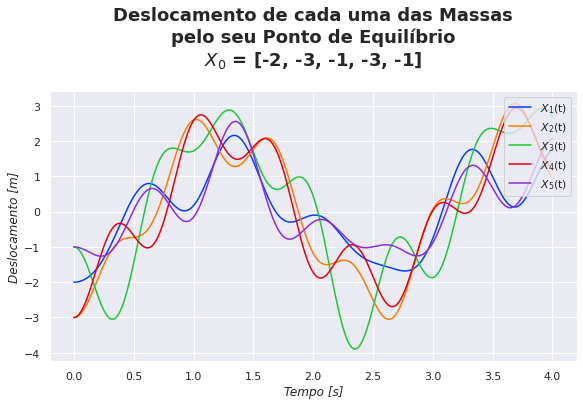

In [22]:
df = make_graphs(X0, A, 4,
                 title="Deslocamento de cada uma das Massas\npelo seu Ponto de Equilíbrio\n" + r"$X_{0}$" + " = [-2, -3, -1, -3, -1]",
                 dim=(8.26772, 11.6929/2))

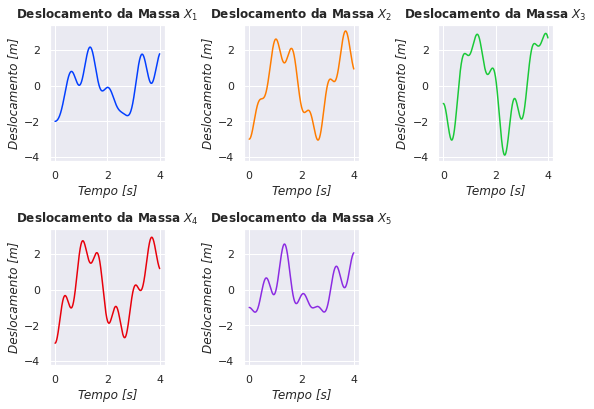

In [23]:
multiple_graphs_5(X0, df)

In [24]:
im1 = cv2.imread(str(X0)+'.png')
im2 = cv2.imread("splt " + str(X0)+'.png')

im_v = cv2.vconcat([im1, im2])
cv2.imwrite('Gráfico 1.1.png', im_v)

True

## Gráfico 2

In [25]:
X0 = np.array([1, 10, -4, 3, -2])

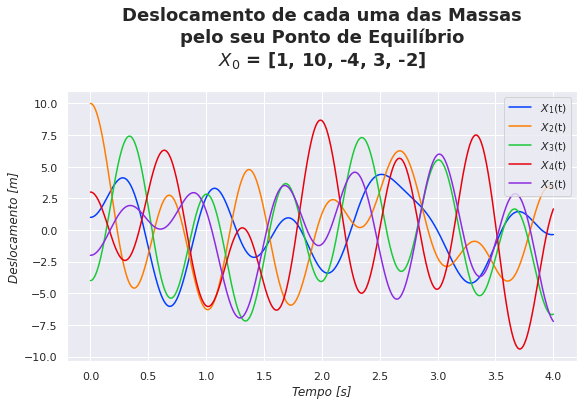

In [26]:
df = make_graphs(X0, A, 4,
                 title="Deslocamento de cada uma das Massas\npelo seu Ponto de Equilíbrio\n" + r"$X_{0}$" + " = [1, 10, -4, 3, -2]",
                 dim=(8.26772, 11.6929/2))

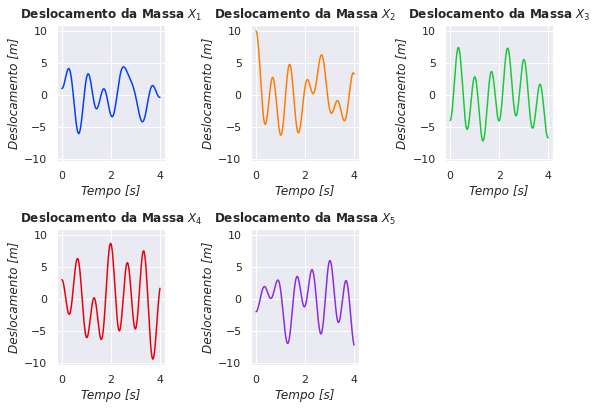

In [27]:
multiple_graphs_5(X0, df)

In [28]:
im1 = cv2.imread(str(X0)+'.png')
im2 = cv2.imread("splt " + str(X0)+'.png')

im_v = cv2.vconcat([im1, im2])
cv2.imwrite('Gráfico 1.2.png', im_v)

True

## Gráfico 3

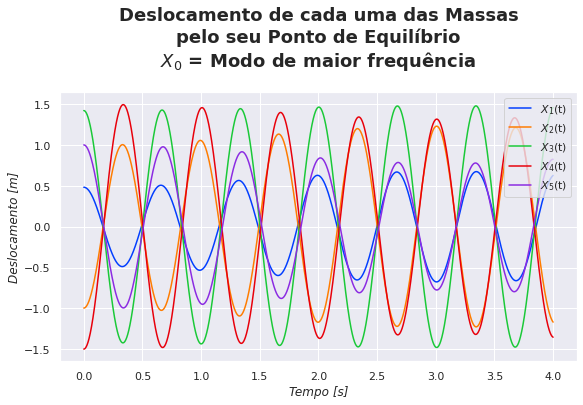

In [29]:
X0 = Λ[0]
df = make_graphs(X0, A, 4,
                 title="Deslocamento de cada uma das Massas\npelo seu Ponto de Equilíbrio\n" + r"$X_{0}$" + " = Modo de maior frequência",
                 dim=(8.26772, 11.6929/2))

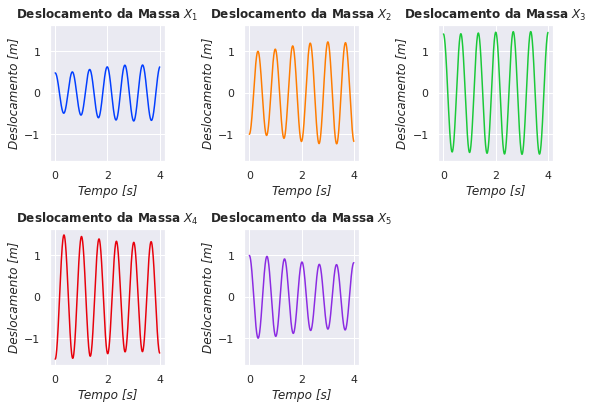

In [30]:
multiple_graphs_5(X0, df)

In [31]:
im1 = cv2.imread(str(X0)+'.png')
im2 = cv2.imread("splt " + str(X0)+'.png')

im_v = cv2.vconcat([im1, im2])
cv2.imwrite('Gráfico 1.3.png', im_v)

True

# Tarefa 3 - Massa Mola

In [32]:
A = np.zeros((10, 10))
k = [40 + 2*(-1)**i for i in np.arange(1, 12)]
A[K_diagonal_indices(A,  0)] = np.array([k[i] + k[i+1] for i in range(len(k) - 1)])
A[K_diagonal_indices(A, -1)] = np.array([-k[i] for i in range(1, len(k) - 1)])
A[K_diagonal_indices(A,  1)] = np.array([-k[i] for i in range(1, len(k) - 1)])
A = 1/2 * A

A

array([[ 40., -21.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [-21.,  40., -19.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., -19.,  40., -21.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0., -21.,  40., -19.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0., -19.,  40., -21.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., -21.,  40., -19.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., -19.,  40., -21.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., -21.,  40., -19.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., -19.,  40., -21.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -21.,  40.]])

In [33]:
Autovalores, Autovetores, _ = QR_algorithm(A)

In [34]:
ω = []
print("Frequências de vibração ω = √λ:")
for i in range(len(Autovalores)):
    ω.append(np.sqrt(Autovalores[i]))
    print("ω{}:".format(i + 1), ω[i])
ω = np.asarray(ω)
print()
Λ = []
print("Modos naturais de vibração Λ:")
for i in range(len(Autovetores)):
    Λ.append(Autovetores[i]/Autovetores[i, -1])
    print("Λ{}:".format(i + 1), Λ[i])
Λ = np.asarray(Λ)

Frequências de vibração ω = √λ:
ω1: 8.85309744815691
ω2: 8.58786012111241
ω3: 8.148236526180936
ω4: 7.554068492924068
ω5: 6.855754680314459
ω6: 5.74444320742632
ω7: 4.789159550924558
ω8: 3.688663919823931
ω9: 2.5040112006728408
ω10: 1.2654058718647274

Modos naturais de vibração Λ:
Λ1: [-1.29915074  2.34225816 -3.23873421  3.74481125 -3.93888977  3.79854256
 -3.34053797  2.7163765  -1.86176612  1.        ]
Λ2: [ 0.93159749 -1.48871603  1.59782953 -1.19978471  0.33800755  0.56820551
 -1.41058242  1.77500127 -1.61379083  1.        ]
Λ3: [-1.          1.25684564 -0.64067791 -0.33191282  1.16919278 -1.16919278
  0.33191281  0.64067791 -1.25684564  1.        ]
Λ4: [ 1.         -0.81256908 -0.37549269  1.0402953  -0.51927375 -0.51927376
  1.0402953  -0.37549269 -0.81256908  1.        ]
Λ5: [-0.99999992  0.33339868  0.98240791 -0.62917995 -0.85397071  0.85397077
  0.6291799  -0.98240799 -0.33339865  1.        ]
Λ6: [ 1.          0.33339864 -0.98240801 -0.62917989  0.85397083  0.85397072
 -0.6

In [35]:
def multiple_graphs_10(X0, df):
    sns.set(rc={'figure.figsize':(11.69291*2, 8.26772)})
    colors = sns.color_palette("bright", len(X0))

    ax1  = plt.subplot(2, 5, 1 )
    ax2  = plt.subplot(2, 5, 2 , sharex=ax1, sharey=ax1)
    ax3  = plt.subplot(2, 5, 3 , sharex=ax1, sharey=ax1)
    ax4  = plt.subplot(2, 5, 4 , sharex=ax1, sharey=ax1)
    ax5  = plt.subplot(2, 5, 5 , sharex=ax1, sharey=ax1)
    ax6  = plt.subplot(2, 5, 6 , sharex=ax1, sharey=ax1)
    ax7  = plt.subplot(2, 5, 7 , sharex=ax1, sharey=ax1)
    ax8  = plt.subplot(2, 5, 8 , sharex=ax1, sharey=ax1)
    ax9  = plt.subplot(2, 5, 9 , sharex=ax1, sharey=ax1)
    ax10 = plt.subplot(2, 5, 10, sharex=ax1, sharey=ax1)

    sns.lineplot(ax=ax1, x='Time', y='X1', data=df, color=colors[1 -1])
    sns.lineplot(ax=ax2, x='Time', y='X2', data=df, color=colors[2 -1])
    sns.lineplot(ax=ax3, x='Time', y='X3', data=df, color=colors[3 -1])
    sns.lineplot(ax=ax4, x='Time', y='X4', data=df, color=colors[4 -1])
    sns.lineplot(ax=ax5, x='Time', y='X5', data=df, color=colors[5 -1])
    sns.lineplot(ax=ax6, x='Time', y='X6', data=df, color=colors[6 -1])
    sns.lineplot(ax=ax7, x='Time', y='X7', data=df, color=colors[7 -1])
    sns.lineplot(ax=ax8, x='Time', y='X8', data=df, color=colors[8 -1])
    sns.lineplot(ax=ax9, x='Time', y='X9', data=df, color=colors[9 -1])
    sns.lineplot(ax=ax10, x='Time', y='X10', data=df, color=colors[10-1])

    ax1.set_title("Deslocamento da Massa " + r"$X_{1}$", fontsize=12, fontweight='bold')
    ax2.set_title("Deslocamento da Massa " + r"$X_{2}$", fontsize=12, fontweight='bold')
    ax3.set_title("Deslocamento da Massa " + r"$X_{3}$", fontsize=12, fontweight='bold')
    ax4.set_title("Deslocamento da Massa " + r"$X_{4}$", fontsize=12, fontweight='bold')
    ax5.set_title("Deslocamento da Massa " + r"$X_{5}$", fontsize=12, fontweight='bold')
    ax6.set_title("Deslocamento da Massa " + r"$X_{6}$", fontsize=12, fontweight='bold')
    ax7.set_title("Deslocamento da Massa " + r"$X_{7}$", fontsize=12, fontweight='bold')
    ax8.set_title("Deslocamento da Massa " + r"$X_{8}$", fontsize=12, fontweight='bold')
    ax9.set_title("Deslocamento da Massa " + r"$X_{9}$", fontsize=12, fontweight='bold')
    ax10.set_title("Deslocamento da Massa " + r"$X_{10}$", fontsize=12, fontweight='bold')

    ax1.set_xlabel('Tempo [s]', fontsize=12, fontstyle='italic')
    ax2.set_xlabel('Tempo [s]', fontsize=12, fontstyle='italic')
    ax3.set_xlabel('Tempo [s]', fontsize=12, fontstyle='italic')
    ax4.set_xlabel('Tempo [s]', fontsize=12, fontstyle='italic')
    ax5.set_xlabel('Tempo [s]', fontsize=12, fontstyle='italic')
    ax6.set_xlabel('Tempo [s]', fontsize=12, fontstyle='italic')
    ax7.set_xlabel('Tempo [s]', fontsize=12, fontstyle='italic')
    ax8.set_xlabel('Tempo [s]', fontsize=12, fontstyle='italic')
    ax9.set_xlabel('Tempo [s]', fontsize=12, fontstyle='italic')
    ax10.set_xlabel('Tempo [s]', fontsize=12, fontstyle='italic')

    ax1.set_ylabel('Deslocamento [m]', fontsize=12, fontstyle='italic')
    ax2.set_ylabel('Deslocamento [m]', fontsize=12, fontstyle='italic')
    ax3.set_ylabel('Deslocamento [m]', fontsize=12, fontstyle='italic')
    ax4.set_ylabel('Deslocamento [m]', fontsize=12, fontstyle='italic')
    ax5.set_ylabel('Deslocamento [m]', fontsize=12, fontstyle='italic')
    ax6.set_ylabel('Deslocamento [m]', fontsize=12, fontstyle='italic')
    ax7.set_ylabel('Deslocamento [m]', fontsize=12, fontstyle='italic')
    ax8.set_ylabel('Deslocamento [m]', fontsize=12, fontstyle='italic')
    ax9.set_ylabel('Deslocamento [m]', fontsize=12, fontstyle='italic')
    ax10.set_ylabel('Deslocamento [m]', fontsize=12, fontstyle='italic')

    plt.tight_layout()

    fig = plt.gcf()
    fig.savefig("splt " + str(X0) + ".png", format='png', dpi=200)

    plt.show()

In [36]:
t = 4

## Gráfico 1

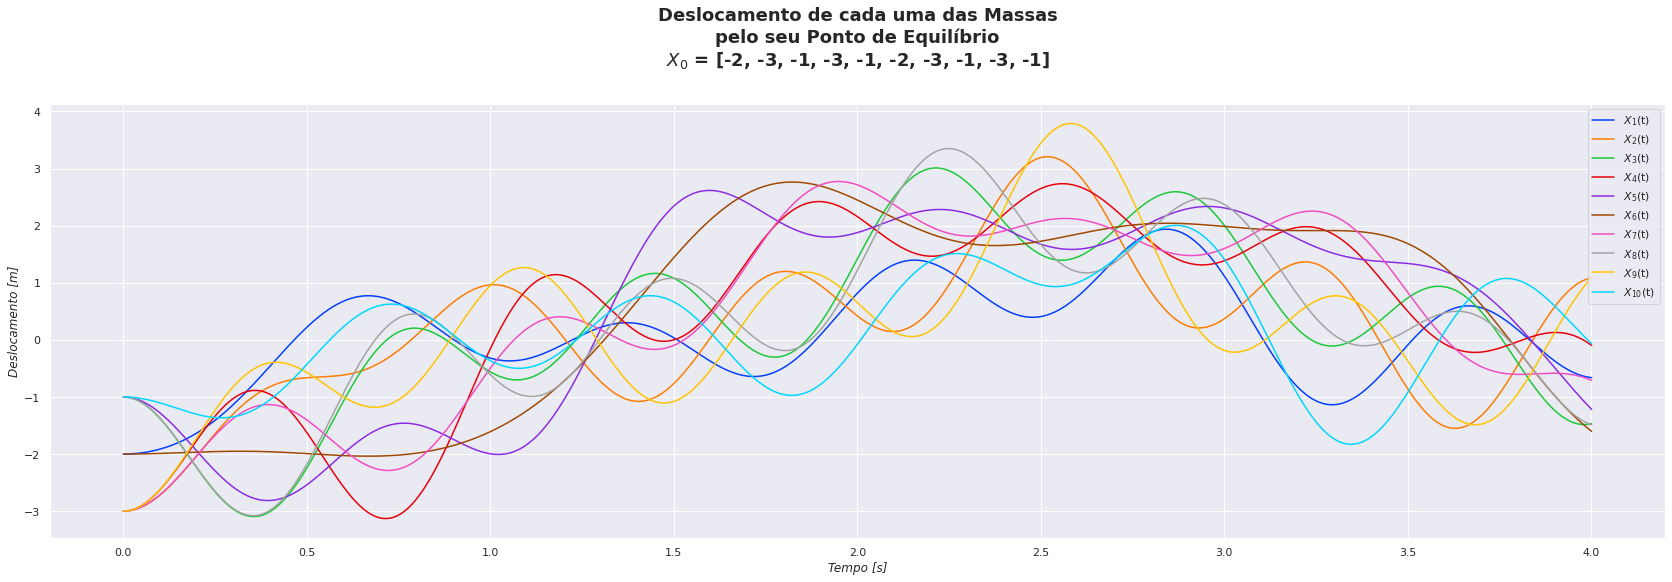

In [37]:
X0 = np.array([-2, -3, -1, -3, -1, -2, -3, -1, -3, -1])
df = make_graphs(X0, A, t, title="Deslocamento de cada uma das Massas\npelo seu Ponto de Equilíbrio\n" + r"$X_{0}$" + " = [-2, -3, -1, -3, -1, -2, -3, -1, -3, -1]")

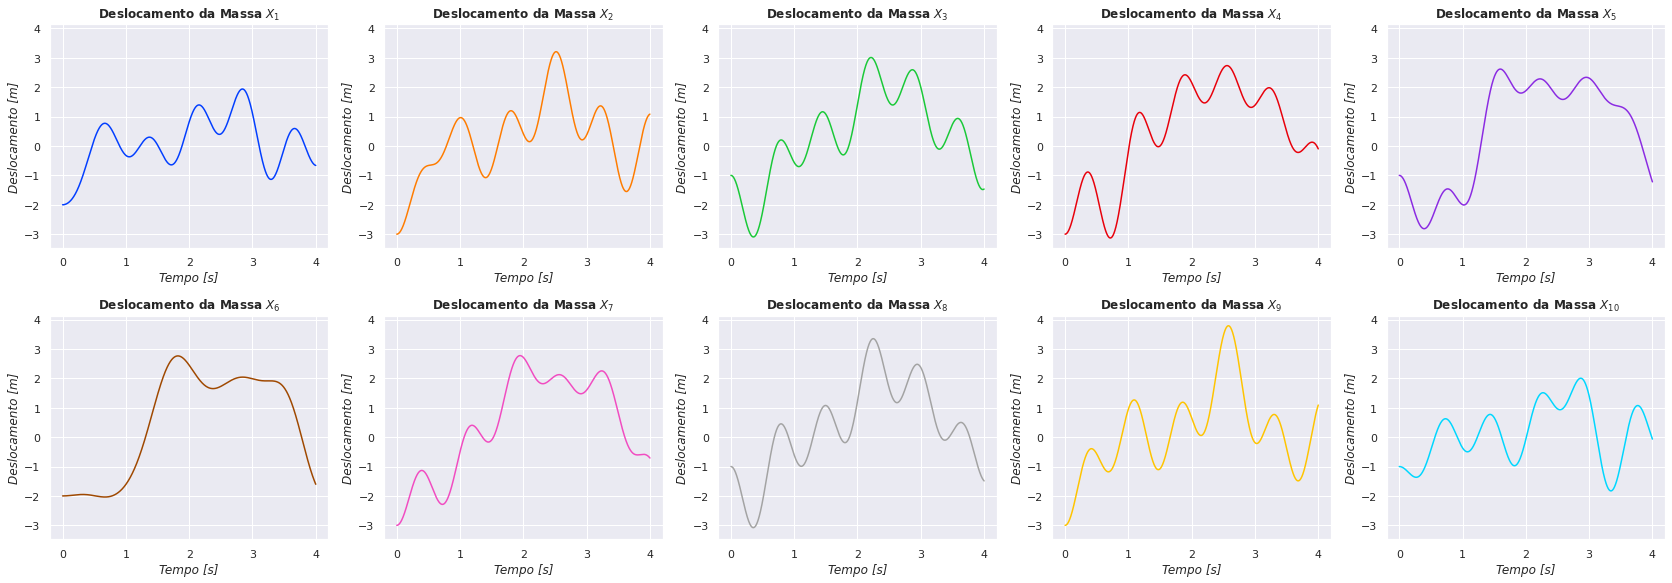

In [38]:
multiple_graphs_10(X0, df)

In [39]:
im1 = cv2.imread(str(X0)+'.png')
im2 = cv2.imread("splt " + str(X0)+'.png')

im_v = cv2.vconcat([im1, im2])
cv2.imwrite('Gráfico 2.1.png', im_v)

True

## Gráfico 2

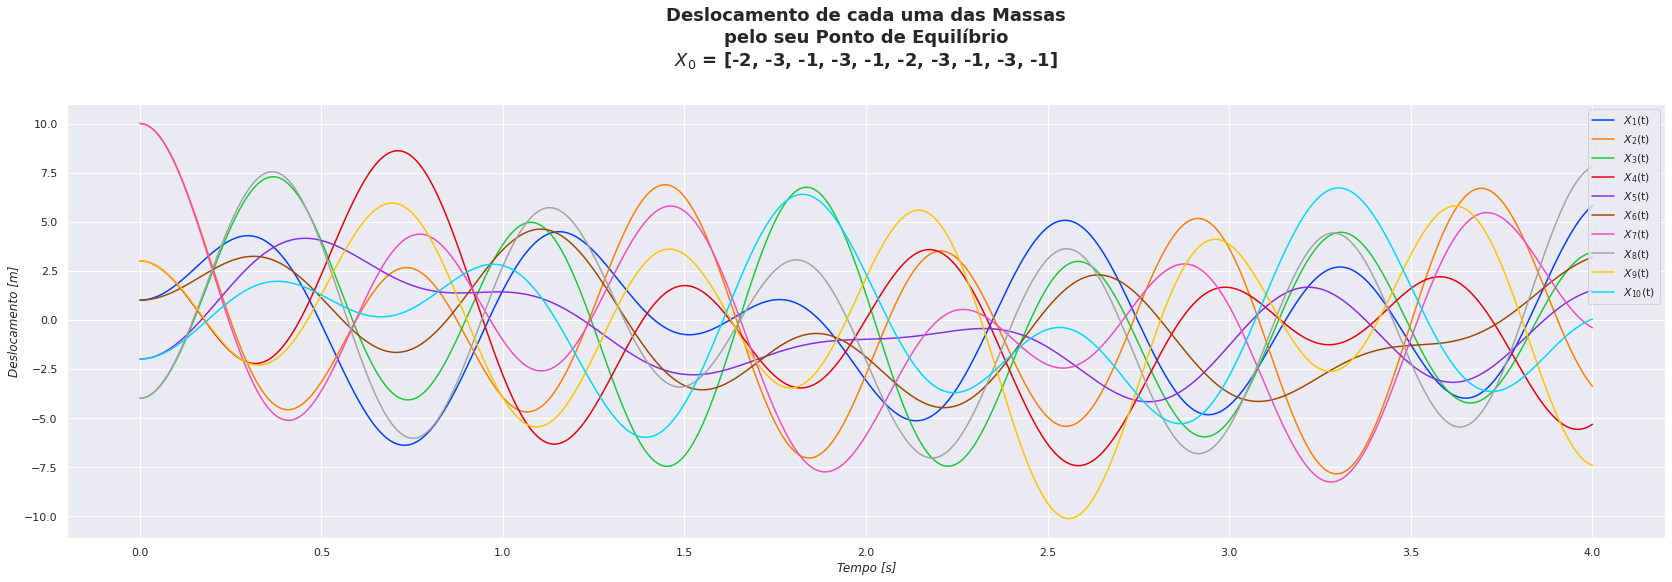

In [40]:
X0 = np.array([1, 10, -4, 3, -2, 1, 10, -4, 3, -2])
df = make_graphs(X0, A, t, title="Deslocamento de cada uma das Massas\npelo seu Ponto de Equilíbrio\n" + r"$X_{0}$" + " = [-2, -3, -1, -3, -1, -2, -3, -1, -3, -1]")

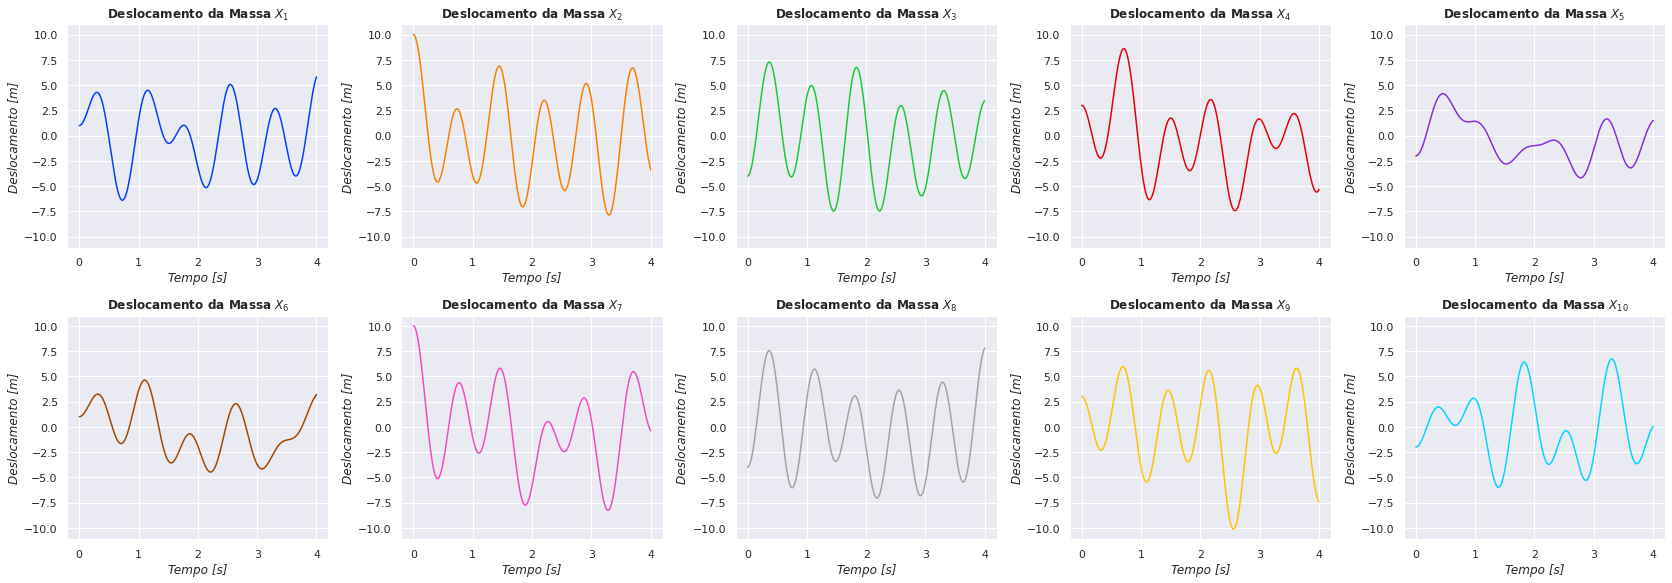

In [41]:
multiple_graphs_10(X0, df)

In [42]:
im1 = cv2.imread(str(X0)+'.png')
im2 = cv2.imread("splt " + str(X0)+'.png')

im_v = cv2.vconcat([im1, im2])
cv2.imwrite('Gráfico 2.2.png', im_v)

True

## Gráfico 3

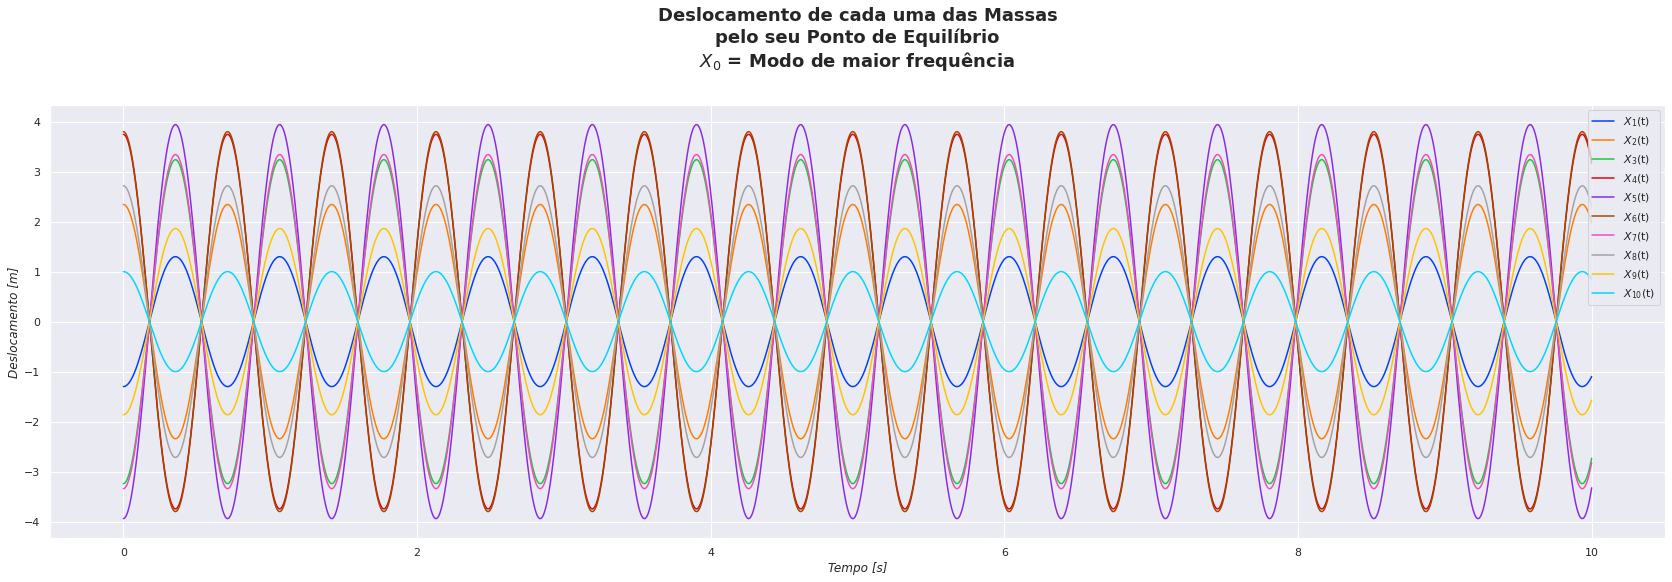

In [43]:
X0 = np.array(Λ[0])
df = make_graphs(X0, A, 10, title="Deslocamento de cada uma das Massas\npelo seu Ponto de Equilíbrio\n" + r"$X_{0}$" + " = Modo de maior frequência")

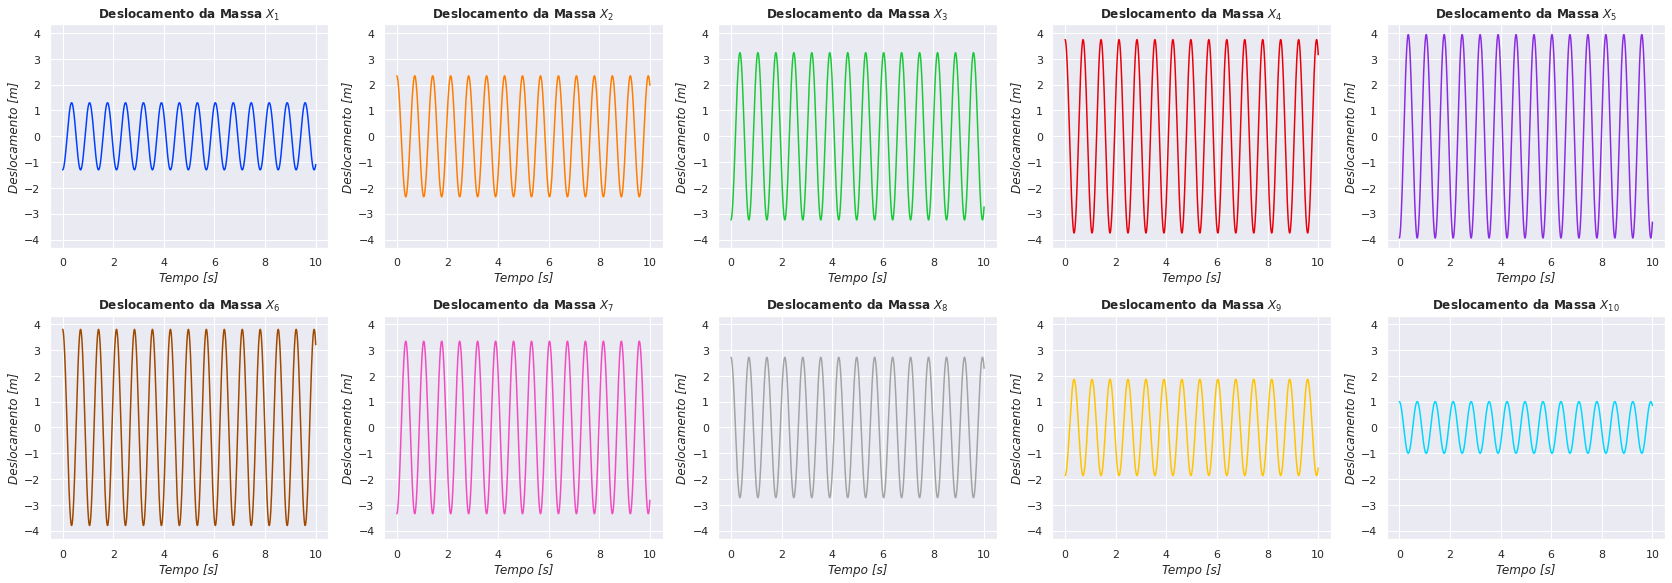

In [44]:
multiple_graphs_10(X0, df)

In [45]:
im1 = cv2.imread(str(X0)+'.png')
im2 = cv2.imread("splt " + str(X0)+'.png')

im_v = cv2.vconcat([im1, im2])
cv2.imwrite('Gráfico 2.3.png', im_v)

True